<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/fmottes/unito-neural-networks/blob/master/03%20-%20Fully%20Connected%20Feedforward%20Networks%20with%20TensorFlow.ipynb">
      <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab" style="width:175px;"/>
    </a>
  </td>
</table>

# <center> **Neural Networks** (MFN0824) </center>

### Lectures: _Dr. Matteo Osella_
### Notebooks: _Francesco Mottes_
<br>

---

The reference book for the practical part of this course is:
- *Hands-on Machine Learning with Scikit-Learn, Keras and Tensorflow - A. Géron*

There is also a [github page](https://github.com/ageron/handson-ml2) where you can find some notebooks with the code from the book, a good place to start if you want to look into more advanced topics.

**NOTE:** You can easily (and legally) find online a raw and unedited version of the second edition of the book, released by the author before the book was finished. Be advised that, besides not being the revised version, **it is not even the whole book**.

If you want to play with a dense feedforward artificial neural network without writing any code and with a nice visualization, you can try out the Tensorflow Playground (link in the section below).

### References:
- Numpy Docs: https://numpy.org/doc/1.18/
- Matplotlib Docs: https://matplotlib.org/
- Scikit-learn Docs: https://scikit-learn.org/
- Keras Docs: https://keras.io/api/
- Tensorflow Playground: https://playground.tensorflow.org/

# <center> **03 - Fully Connected Feedforward Networks with TensorFlow** </center>

In this notebook we will implement a simple dense feedforward ANN using the Keras API, that comes embedded into Tensorflow from version 2.0. We will train the network to recognize hand-written digits found in the famous MNIST dataset. Classification of the less trivial FMNIST dataset will be left as an exercise.

First things first, we import the libraries that we will need:

In [1]:
#standard imports
import numpy as np
import matplotlib.pyplot as plt

#import tensorflow and keras
import tensorflow as tf
from tensorflow import keras


#function for fast generation of training and test set from data
from sklearn.model_selection import train_test_split

In [2]:
# check tensorflow and keras versions
print(tf.__version__)
print(keras.__version__)

2.1.0
2.2.4-tf


## <center> **Loading MNIST** </center>

Some small and simple datasets come with the keras library and can be uploaded into a project almost without any effort. You can find a list of the directly uploadable datasets in the Keras docs.

In [3]:
from keras.datasets import mnist

#load actual data
(X_train, y_train), (X_test, y_test) = mnist.load_data()

Using TensorFlow backend.


The MNIST dataset contains hand-written, single digits in the range 0-9, together with their correct classification. Digits are stored as grayscale images with size 28x28 pixels, represented as Numpy arrays of shape (28,28) and entries in the range 0-255.

As for datasets loaded through scikit-learn, also in this case a division into training set and test set is already provided: 60000 images are loaded as training samples and 10000 as test sample. Note that, in order to have a sound machine learning pipeline, we will also need to build ourselves a validation set.

In [4]:
#check shape of the training set
print('TRAINING SET:\t',X_train.shape)

#check shape of the test set
print('TEST SET:\t', X_test.shape)

TRAINING SET:	 (60000, 28, 28)
TEST SET:	 (10000, 28, 28)


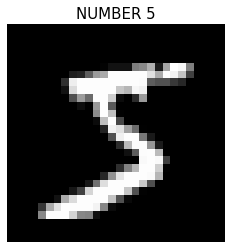

In [5]:
#show first image contained in the training data, with its label

plt.imshow(X_train[0], cmap='gray')
plt.title('NUMBER {}'.format(y_train[0]), fontsize=15)
plt.axis('off'); #do not show spines

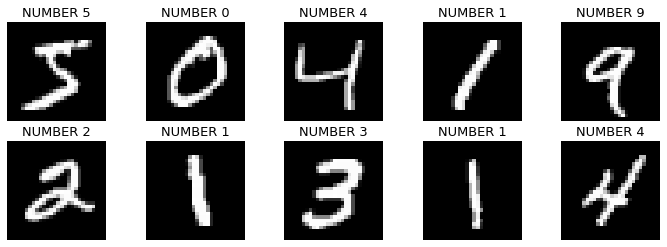

In [6]:
# show the first 10 images in the training set

fig, axs = plt.subplots(2,5,figsize=(12,4))

for i in range(10):
    
    ax = axs.ravel()[i]
    
    ax.imshow(X_train[i], cmap='gray')
    ax.set_title('NUMBER {}'.format(y_train[i]), fontsize=13)
    ax.axis('off')

Note that the classes in the dataset are not balanced. This is usually something you want to take into account when training a machine learning algorithm, either by balancing classes by eliminating some samples from the most populated ones or by means of more sophisticated techniques. Since this problem is not a real issue for this dataset and is not an argument strictly connected with ANNs we will not address it here.

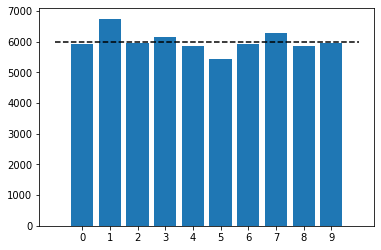

In [7]:
plt.hlines(6000, -1, 10, linestyles='--')

plt.hist(y_train, bins=np.linspace(-.5,9.5,11), rwidth=.8)
plt.xticks(range(10));

We now need to split the training set into training and validation set:

In [8]:
val_size = .1 #use 6000 samples as validation set

#generate training and test set with stratification
#this means that we will find the same proportion of classes bot in the validation and in the training set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=val_size, stratify=y_train)

And finally transform the data in a format more suitable for use in training a neural network:

In [9]:
#rescale pixel values to the range (0,1)
X_train = X_train/255
X_val = X_val/255
X_test = X_test/255

In [10]:
#transform integer label into one-hot encodings
n_classes=10

y_train_cat = keras.utils.to_categorical(y_train, n_classes)
y_val_cat = keras.utils.to_categorical(y_val, n_classes)
y_test_cat = keras.utils.to_categorical(y_test, n_classes)

## <center> **ANNs with the Keras Sequential API** </center>

Keras provides a simple way to build ANNs - as the one shown below - composed only of layers stacked one on top of the other. This is done by passing a list of pre-implemented layer types to the Sequential API. Each layer object manages its own weight matrix, connecting its neurons to their inputs, and its own bias vector, one per neuron.

![A Dense Feed-Forward Artificial Neural Network](img/FF-ANN.png)

**Note:** Unlike most of the python code that we have seen up to now, training a neural network happens in two distinct phases. 
* The first is a DECLARATIVE one, you have to tell Keras what is the design of your neural network: how many layers do you want? how big each layer will be? which type of activation function do you want? what loss function do you want to minimize? which optimizer do you want to use? what metric you want to keep track of? In this phase no actual training happens quite yet.
* The second phase is when you actually train your model. You need to specify some additional parameters like number of epochs, batch size, training and validation data.

In [11]:
#a few more imports for readability

#import backbone of the model
from keras.models import Sequential

#import the two types of layes we need
from keras.layers import Flatten, Dense

We will now create a model with a single hidden layer of 15 neurons, which takes as input the MNIST data and outputs the probability of belonging to one of the 10 classes. There are actually a few different but equivalent ways for creating a Sequential model. Choose the one you like the most!

In [12]:
#very important! do it before you instantiate a brand new model
#cleares the backend of all the previous instances of the models 
#which might interfere with the new instance
keras.backend.clear_session()

model = Sequential()
model.add(Flatten(input_shape=(28,28))) #flattens 2d input image into flat array
model.add(Dense(15, activation='tanh')) #15 hidden units with tanh activation
model.add(Dense(n_classes, activation='softmax')) #output layer with softmax activations

In [13]:
#alternative way
keras.backend.clear_session()

model = Sequential([
    Flatten(input_shape=(28,28)),
    Dense(15, activation='tanh'),
    Dense(n_classes, activation='softmax')
])

There are a few of parameters that can be chosen for defining a layer, besides activation and number of neurons. An important one is the initialization strategy for the weights. The default is the so-called "Glorot-uniform" initialization, but there a few different ones with their pros and cons. A list of initializers with a brief description and references can be found [here](https://keras.io/api/layers/initializers/). Biases are initialized to 0 by default.

In [14]:
#explicit initialization strategy, equivalent to the preceding cell
keras.backend.clear_session()

model = Sequential([
    Flatten(input_shape=(28,28)),
    Dense(15, activation='tanh', kernel_initializer='glorot_uniform', bias_initializer='zeros'),
    Dense(n_classes, activation='softmax')
])

In [15]:
#we can now print a summary of the model we created
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 15)                11775     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                160       
Total params: 11,935
Trainable params: 11,935
Non-trainable params: 0
_________________________________________________________________


Note that the number of parameters shown for the first layer corresponds to 784\*15=11760 weights + 15 biases, while in the last layer we have 15\*10+10 parameters.

Now we need to specify the optimizer, the loss function and possibly accuracy metrics to keep track of.

In [17]:
model.compile(
    loss='categorical_crossentropy',
    optimizer='sgd',
    metrics=['accuracy']
)

We have chosen to minimize the categorical cross-entropy loss with plain (Mini-batch) Stochastic Gradient Descent, and keep track of the accuracy metric (the loss metric is included by default). We can also pass as parameters, instead of strings, functions coming from the Keras internal libraries. Further information can be found in the Keras docs, in the sections [Losses](https://keras.io/api/losses/), [Optimizers](https://keras.io/api/optimizers/) and [Metrics](https://keras.io/api/metrics/). Alternatively, one can also pass custom functions that implement algorithms different from the ones present in keras, as long as their implementation is compatible with the rest of the API (see docs).

It is often useful to pass functions, instead of strings. In this case we can also control the parameters of the object that we pass, instead of getting the default parameters:

In [18]:
#compilation equivalent to the one above, only with different learning rate

model.compile(
    loss='categorical_crossentropy',
    optimizer=keras.optimizers.SGD(learning_rate=.02),
    metrics=['accuracy']
)

The network is fully initialized now! We can, for example, look at how the weights are initialized:

In [19]:
#returns a list with the weight matrices and bias vectors, from the input to the output layer
weights = model.get_weights()

print(weights[0].shape) #shape of the first weight matrix
print(weights[1].shape) #shape of the first bias vector
print(weights[1]) #initialized entries of the first bias vector

(784, 15)
(15,)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [22]:
model.layers

In [20]:
#you can also get the weights of a specific layer

output_layer = model.layers[-1]

print(output_layer.get_weights()[0].shape) #weights
print(output_layer.get_weights()[1].shape) #biases

(15, 10)
(10,)


We can check the weights distribution in the first layer. From the docs:

>(Glorot uniform) ...samples from a uniform distribution within [-limit, limit], where limit = sqrt(6 / (fan_in + fan_out)) (fan_in is the number of input units in the weight tensor and fan_out is the number of output units).

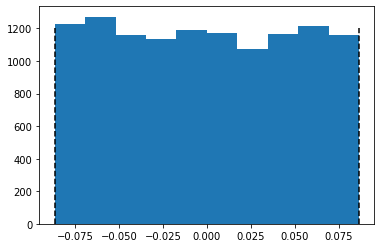

In [30]:
#weinght of the first layer
w0 = model.layers[1].get_weights()[0]

#histogram of the weights
plt.hist(w0.flatten());

#plot the theoretical boundaries
limit = np.sqrt(6/(w0.shape[0]+w0.shape[1]))

plt.vlines(limit, 0, 1200, linestyle='--')
plt.vlines(-limit, 0, 1200,  linestyle='--')

Now we are ready to train the network on the MNIST dataset.

Training data are automatically shuffled at the beginning of each epoch, then divided in batches of the requested size. The algorithm then iterates through the batches and updates the weights accordingly, until all the batches are used and the epoch is declared finished.

In [18]:
#define some hyperparameters

epochs = 30
batch_size = 128

In [19]:
history = model.fit(
    X_train,
    y_train_cat,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_val,y_val_cat),
    verbose=1 #default - show progress bar
    shuffle=True #default, RECOMMENDED - shuffles data at the beginning of each epoch
)

Train on 54000 samples, validate on 6000 samples
Epoch 1/30
54000/54000 [==============================] - 2s 36us/step - loss: 1.4517 - accuracy: 0.6324 - val_loss: 1.0740 - val_accuracy: 0.7492
Epoch 2/30
54000/54000 [==============================] - 2s 29us/step - loss: 0.9026 - accuracy: 0.7973 - val_loss: 0.7965 - val_accuracy: 0.8123
Epoch 3/30
54000/54000 [==============================] - 2s 34us/step - loss: 0.7081 - accuracy: 0.8419 - val_loss: 0.6591 - val_accuracy: 0.8407
Epoch 4/30
54000/54000 [==============================] - 2s 36us/step - loss: 0.6008 - accuracy: 0.8618 - val_loss: 0.5755 - val_accuracy: 0.8605
Epoch 5/30
54000/54000 [==============================] - 1s 25us/step - loss: 0.5321 - accuracy: 0.8736 - val_loss: 0.5196 - val_accuracy: 0.8702
Epoch 6/30
54000/54000 [==============================] - 1s 23us/step - loss: 0.4845 - accuracy: 0.8814 - val_loss: 0.4792 - val_accuracy: 0.8798
Epoch 7/30
54000/54000 [==============================] - 1s 21us/ste

**Note:** If you want to re-train the network from scratch after this step, you will have to call the *clear_backend()* function and re-define the whole network. Every model internally stores the state of the training at which it was stopped, if you don't clear it training will be taken up from where it was stopped before.

We can now evaluate the trained model on the test set and use it to generate predictions for new data.

In [20]:
#evaluate model on the test set
test_loss, test_acc = model.evaluate(X_test, y_test_cat)

print()
print('Test Loss:\t', test_loss)
print('Test Accuracy:\t', test_acc)

10000/10000 [==============================] - 1s 93us/step

Test Loss:	 0.26703420122265814
Test Accuracy:	 0.9248999953269958


In [21]:
#generate probability predictions for the first 5 samples in the test set
model.predict_proba(X_test[:5]).round(2)

array([[0.  , 0.  , 0.  , 0.01, 0.  , 0.  , 0.  , 0.98, 0.  , 0.01],
       [0.01, 0.  , 0.88, 0.04, 0.  , 0.01, 0.05, 0.  , 0.  , 0.  ],
       [0.  , 0.98, 0.01, 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.  ],
       [0.99, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.95, 0.  , 0.  , 0.  , 0.  , 0.03]],
      dtype=float32)

A bunch of logging information about the model and the training is stored in the *history* object. In particular, *history.history* contains the values of the logged accuracy metrics requested at compilation time.

In [22]:
print(history.epoch)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]


In [23]:
history.params

{'batch_size': 128,
 'epochs': 30,
 'steps': None,
 'samples': 54000,
 'verbose': 1,
 'do_validation': True,
 'metrics': ['loss', 'accuracy', 'val_loss', 'val_accuracy']}

In [24]:
#metrics history is saved here
history.history.keys()

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])

Using the data contained in the history dictionary we can construct the **learning curves** associated with the training of our model.

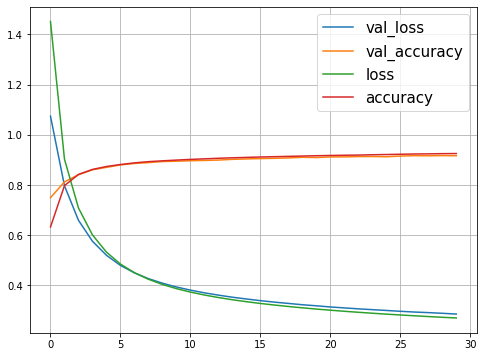

In [25]:
#plot learning curves

fig, ax = plt.subplots(figsize=(8,6))

for metric in history.history:
    ax.plot(history.epoch, history.history[metric], label=metric)
    
ax.grid()    

ax.legend(fontsize=15);

Notice how, in this case, both the training and the validation metrics follow the same trend (increasing or decreasing, depending on which metric), which is a sign that no overfitting is occurring. Notice also that the training and validation curves always stay close to each other, which means that our model will likely generalize pretty well to unseen data.

**Subtlety:** Note that during the first epochs it seems that the model is performing better on the validation data than on the training data. This is due to the fact that the training metrics are calculated as a mean value over all of the batches in an epoch, while validation metrics are calculated at the end of each epoch. In the first epochs the model learns quickly, thus difference in error between the first and the last batch is higher, and the mean score of the epoch is dragged down by the bad scores of the first batches while the validdation does not suffer from this effect. In order to manually correct for this bias, one can shift the training curves half an epoch to the left as done below: note how now the curves pretty much coincide in the beginning. This effect ususally becomes negligible after a small number of epochs, so this correction can be safely ignored in most cases.

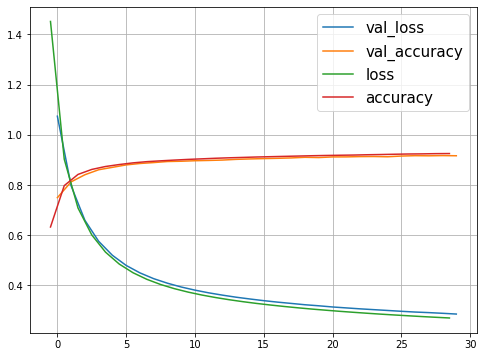

In [26]:
#plot learning curves

fig, ax = plt.subplots(figsize=(8,6))

for metric in history.history:
    if len(metric.split('_')) < 2:
        ax.plot(np.array(history.epoch)-.5, history.history[metric], label=metric)
    else:
        ax.plot(history.epoch, history.history[metric], label=metric)
    
ax.grid()    

ax.legend(fontsize=15);

We can also visualize the wrong predictions, in order to understand where the model fails.

In [27]:
#identify wrong predictions in the training set

y_train_pred = model.predict_classes(X_train)

idx_wrong = np.where(y_train_pred != y_train)[0] #positions of the wrongly classified data

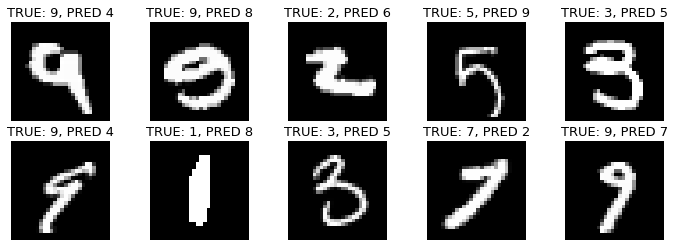

In [28]:
# show the first 10 wrong predictions the training set

fig, axs = plt.subplots(2,5,figsize=(12,4))

for i in range(10):
    
    ax = axs.ravel()[i]
    
    idx = idx_wrong[i]
    
    ax.imshow(X_train[idx], cmap='gray')
    ax.set_title('TRUE: {}, PRED {}'.format(y_train[idx], y_train_pred[idx]), fontsize=13)
    ax.axis('off')

Our still makes a few errors after such a short training, but it seems that most of them are somehow *reasonable*.

## <center> **Saving and loading trained models** </center>

Training a DL model is usually a time and resource consuming activity, so one does not usually want to start all over again every time. Keras provide a very easy way to save and load complete models (and/or their weights). This is also a useful feature if one wants to use big pre-trained models which would be infeasible to train from scratch (like AlexNet, VGG etc.).  

In [29]:
#save trained model in the cache folder
model.save('cache/03.SimpleDense.MNIST.h5')

In [30]:
# load saved model
model = keras.models.load_model('cache/03.SimpleDense.MNIST.h5')

In [31]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 15)                11775     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                160       
Total params: 11,935
Trainable params: 11,935
Non-trainable params: 0
_________________________________________________________________


In [32]:
#evaluate loaded model on the test set
test_loss, test_acc = model.evaluate(X_test, y_test_cat)

print()
print('Test Loss:\t', test_loss)
print('Test Accuracy:\t', test_acc)

10000/10000 [==============================] - 1s 116us/sample - loss: 0.2670 - accuracy: 0.9249

Test Loss:	 0.26703420122265814
Test Accuracy:	 0.9249


## <center> **Transfer Learning** </center>

Keras allows you to easily load a lot of big and famous models to implement in your pipeline. A list of available models and instructions on how to load them is available [here](https://keras.io/api/applications/) in the keras docs.

One of the things that make trained models very useful is the possibility of using them in **transfer learning** strategies. Transfer learning consists of taking a neural network trained on a task different from the one you have at hand, but close enough. For example, you might have a network trained to distingush pictures of cats and dogs, but you want to distingish cats and horses. Its not quite the same task, but you suspect that some of the knowledge that your pre-trained network contains might speed up your learning on the new task. You can take the pre-trained network and, for example, freeze the weights up to the last layer, the re-train only the last layer from scratch using data from the new task. If it works you have saved a lot of training time and got a network fine-tuned for your new task. This is a pretty effective strategy especially when the pre-trained model is so big that it wuold be almost impossible to train from scratch and gives great results in many contexts.

Transfer learning will be explained more in detail in the next course lectures. If you want more practical details on how to do this in keras you can look [here](https://keras.io/guides/transfer_learning/).

## <center> **Exercises** </center>

### Play with the code 

As always, the best way to understand is to change things and try to understand what happens. In neural networks there surely is not shortage of things you can change and get very different results: activations, loss function, epochs of training, batch size, optimizer, number of layers, number of neurons per layer, ...

### F-MNIST Dataset

Another toy dataset which is frequently used is the Fashion-MNIST dataset. It has the advantage of being more difficult to learn for a neural network, while retaining the feature that made MNIST so widespread, like small size, abundance of data both for training and testing and being easy to handle. The ten classes in this case are categories of fashion items and clothes, images are 28x28 b/w as is for MNIST. The dataset is readily available inside keras, follow the steps presented above in order to train a network on this new dataset.

**Note:** You will need to apply also here the preprocessing steps!

In [33]:
# load FMINST data

from keras.datasets import fashion_mnist

#load actual data
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

print(X_train.shape)
print(X_test.shape)

(60000, 28, 28)
(10000, 28, 28)


In [34]:
#class names are not provided with the data
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

d_class_name = dict(zip(range(10),class_names))

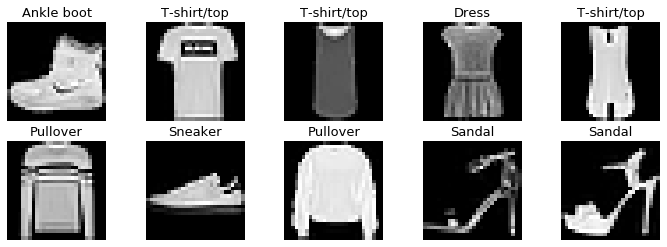

In [35]:
# show the first 10 images in the training set

fig, axs = plt.subplots(2,5,figsize=(12,4))

for i in range(10):
    
    ax = axs.ravel()[i]
    
    ax.imshow(X_train[i], cmap='gray')
    ax.set_title('{}'.format(d_class_name[y_train[i]]), fontsize=13)
    ax.axis('off')

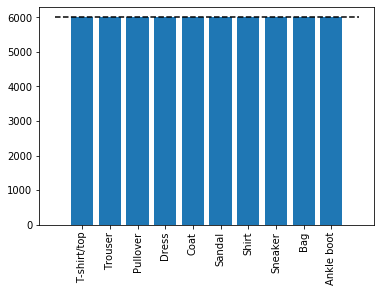

In [36]:
plt.hlines(6000, -1, 10, linestyles='--')

plt.hist(y_train, bins=np.linspace(-.5,9.5,11), rwidth=.8)
plt.xticks(range(10), labels=class_names, rotation=90);

### Moons Synthethic Dataset

Use the code from the previous notebook to generate the moons dataset with scikit-learn, then train a neural network on the data. Since the dataset is 2D you can easily visualize the decision boundary of the trained neural network and make comparisons with the perceptron boundary!

In [37]:
from sklearn.datasets import make_moons

N = 10000
test_size = .1

#generate two semi-circles, one for each class, of 2D data
#(we don't get to choose the data dimension here, it's always 2D)
X_moon, y_moon = make_moons(n_samples=N, noise=.1)

#generate training and test set
X_moon_train, X_moon_test, y_moon_train, y_moon_test = train_test_split(X_moon, y_moon, test_size=test_size)

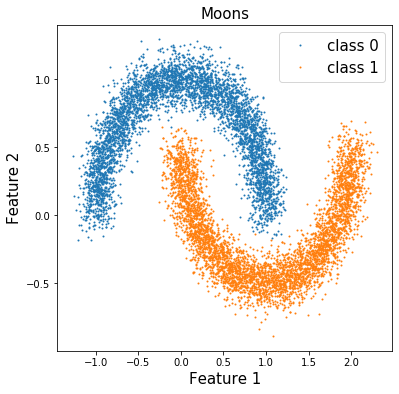

In [38]:
#plot the blob dataset

fig, ax = plt.subplots(figsize=(6,6))

fontsize = 15

#plot both classes as above, but all at once
for cat in np.unique(y_moon_train): #loop over unique class IDs
    
    mask = y_moon_train == cat
    
    ax.plot(X_moon_train[mask][:,0], X_moon_train[mask][:,1], 'o', markersize=1, label='class {}'.format(cat))



ax.legend(fontsize=fontsize)

ax.set_xlabel('Feature 1', fontsize=fontsize)
ax.set_ylabel('Feature 2', fontsize=fontsize)

ax.set_title('Moons', fontsize=fontsize);

In [ ]:
# TRAIN YOUR NEURAL NETWORK HERE

model = Sequential()

#.......


In [ ]:
#visualize prediction boundary on moons dataset

fig, ax = plt.subplots(figsize=(6,6))

fontsize = 15

#----------------------------------------------------------------
### VISUALIZE BLOBS TRAINIG DATASET (with correct classification)


#plot the points of the first class:
mask = y_moon_train == 0

ax.plot(X_moon_train[mask][:,0], X_moon_train[mask][:,1], 'o', label='class 0') #plot first feature on x-axis and second feature on y-axis


#plot the points of the second class:
mask = y_moon_train == 1

ax.plot(X_moon_train[mask][:,0], X_moon_train[mask][:,1], 'o', label='class 1') #plot first feature on x-axis and second feature on y-axis

#----------------------------------------------------------------
### Visualize perceptron's prediction field

# generate square mesh of points to evaluate, with "n_pts_side" ponits per side
n_pts_side = 500
pad = .5

#extrema change based on generated points
xx_min = X_moon[:,0].min()-pad
xx_max = X_moon[:,0].max()+pad

yy_min = X_moon[:,1].min()-pad
yy_max = X_moon[:,1].max()+pad

xx = np.linspace(xx_min, xx_max, n_pts_side)  
yy = np.linspace(yy_min, yy_max, n_pts_side)


# plot decision field
xx, yy = np.meshgrid(xx, yy)

zz = model.predict_classes(np.vstack([xx.ravel(),yy.ravel()]).T) #generate predictions for each point in field
zz = zz.reshape(xx.shape)

ax.contourf(xx, yy, zz, levels=2, colors=('deepskyblue','k','orangered'), alpha=.1)

#----------------------------------------------------------------

ax.set_xlim(xx_min, xx_max)
ax.set_ylim(yy_min, yy_max)

ax.legend(fontsize=fontsize)

ax.set_xlabel('Feature 1', fontsize=fontsize)
ax.set_ylabel('Feature 2', fontsize=fontsize)

ax.set_title('Blobs', fontsize=fontsize);